In [1]:
import sys
from pathlib import Path

parent = str(Path().resolve().parent)
if parent not in sys.path:
    sys.path.insert(0, parent)

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from functions.plotting_networks import plot_2graphs, scatter_dist

In [3]:
with open("../data/wip/Musicians_graph.pkl", "rb") as f:
    G = pickle.load(f)

We calculate the probability (p) average degree (k) of the network 
ref[Section 3.2, equation (3.2) in Network Science, Albert-Laszlo Barabasi]

In [4]:
N = G.number_of_nodes()
L = G.number_of_edges()

p = L / ((N*(N-1))/2)  # for undirected graphs, we divide by 2

k = p*(G.number_of_nodes() - 1)

print(f"Size of network: {N}")
print(f"Probability: {p}")
print(f"Average degree: {k}")

Size of network: 4151
Probability: 0.004870476848371563
Average degree: 20.212478920741987


The average degreee is 20, so on average a musician is sharing associated music groups with 20 other musicians.
___

Now, we write a function to generate a Random Network that mirrors the Danish Musicians Network in terms of node count, using your calculated p. We generate the random network by linking nodes in every possible pair with probability.

In [5]:
def random_network(N,p):
    
    #Start with N isolated nodes.
    R = nx.Graph()
    R.add_nodes_from(range(N))

    #Select a node pair and generate a random number between 0 and 1
    for u in range(N):
        for v in range(u+1,N):
            if np.random.rand() < p: #If the number exceeds p:
                R.add_edge(u,v) #connect the selected node pair with a link, otherwise leave them disconnected.
    return R

F = random_network(N,p)

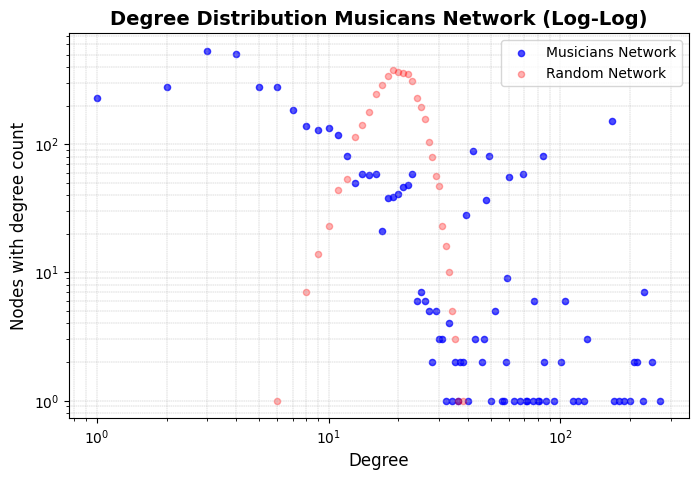

In [6]:
def scatter_dist(G, F):
    def get_deg_dist(graph):
        degree_dict = dict(graph.degree())
        return np.unique(list(degree_dict.values()), return_counts=True)

    # Get degree distributions
    degs_G, counts_G = get_deg_dist(G)
    degs_F, counts_F = get_deg_dist(F)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(degs_G, counts_G, s=20, alpha=0.7, label='Musicians Network', color='blue')
    plt.scatter(degs_F, counts_F, s=20, alpha=0.3, label='Random Network', color='red')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree", fontsize=12)
    plt.ylabel("Nodes with degree count", fontsize=12)
    plt.title("Degree Distribution Musicans Network (Log-Log)", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.3)
    plt.show()

scatter_dist(G,F)

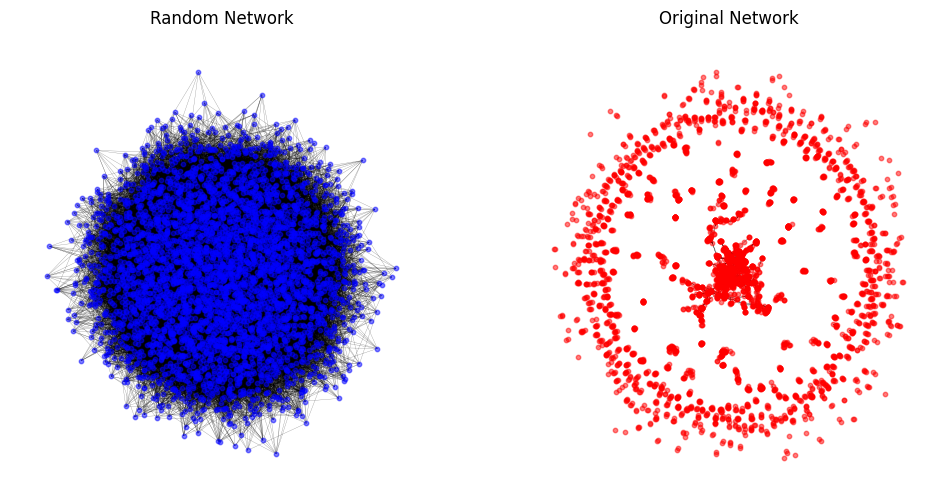

In [7]:
plot_2graphs(G, F)

In [8]:
G_components = nx.connected_components(G)
G_largest_component = max(G_components, key=len)
G_giant = G.subgraph(G_largest_component)


F_components = nx.connected_components(F)
F_largest_component = max(F_components, key=len)
F_giant = F.subgraph(F_largest_component)

# calculate size of the largest component
G_largest_size = len(G_largest_component)
F_largest_size = len(F_largest_component)
print(f"Size of the largest component in G: {G_largest_size}")
print(f"Size of the largest component in F: {F_largest_size}")

Size of the largest component in G: 1718
Size of the largest component in F: 4151


We see a big diffence between the networks. The random network is fully connected and in the super-critical regime as k = 20 >> 1. In contrast, the musicians network is disconected, this makes sense because many musicians are solo artist. However it seems to have a very connected centre. To investigate this further we will try to look only at the giant component.

In [9]:
# To do a fair comparison to a random network, we re-define the random network to mirror the giant.

N_giant = G_giant.number_of_nodes()
p_giant = G_giant.number_of_edges() / ((N_giant*(N_giant-1))/2)  # for undirected graphs, we divide by 2

print(f"Size of giant: {N_giant}")
print(f"Average degree: {p_giant*(N_giant - 1)}")

F_giant = random_network(N_giant,p_giant)

Size of giant: 1718
Average degree: 41.43422584400466


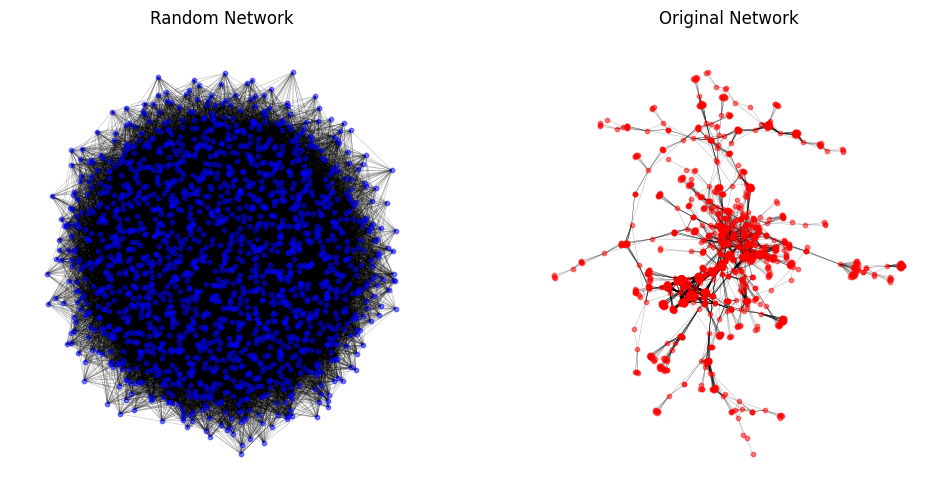

In [10]:
plot_2graphs(G_giant, F_giant)

Looking at the plot, the musicians network seems far from random. This encourage us to investigate possible communities, degree distribution and small world property.

Note: We will from now on only look at the giant component to focus on band-playing musicians. Additionally, this removes most naming-errors in the data and is computational easier to run.

### Small-world property

In [11]:
# Calculate the average shortest path length within the giant:
shortest_G = nx.average_shortest_path_length(G_giant,None)
shortest_F = nx.average_shortest_path_length(F_giant,None)

print(f"Average shortest path length for the giant in the random network: {shortest_F}")
print(f"Average shortest path lenght for the giant in the musicians network: {shortest_G}")

Average shortest path length for the giant in the random network: 2.3350572885132106
Average shortest path lenght for the giant in the musicians network: 6.012429969970906


In [12]:
clustering_G = nx.average_clustering(G_giant)
clustering_F = nx.average_clustering(F_giant)

print(f"Clustering coefficient for the giant in the random network: {clustering_F}")
print(f"Clustering coefficient for the giant in CSS-network: {clustering_G}")

Clustering coefficient for the giant in the random network: 0.024400758202643237
Clustering coefficient for the giant in CSS-network: 0.9273498479059266


The musicans network has an average shortest path of 6, which means that, on average, there is a maximum of around six links between two scientists. This is approximately double the average shortest path in the random network, suggesting that the musicans network may not have small-world properties as $L_{real}$ ≈ $L_{random}$ doesn't hold completely. However, the clustering coefficients calculated below indicate significantly higher clustering than the random network, which is a key characteristic of small-world networks. This suggests that it might possess weak small-world characteristics, aligning more with other social networks than with random structures.

This is a very interesting insight. Muscians tend to cluster strongly but also isolate them selves in more distinct communities. This is comparred to computational social scientists from our earlier assignments,where there $L_{real} = 5.13$ ≈ $L_{random} = 6.15$.

### Degree distribution

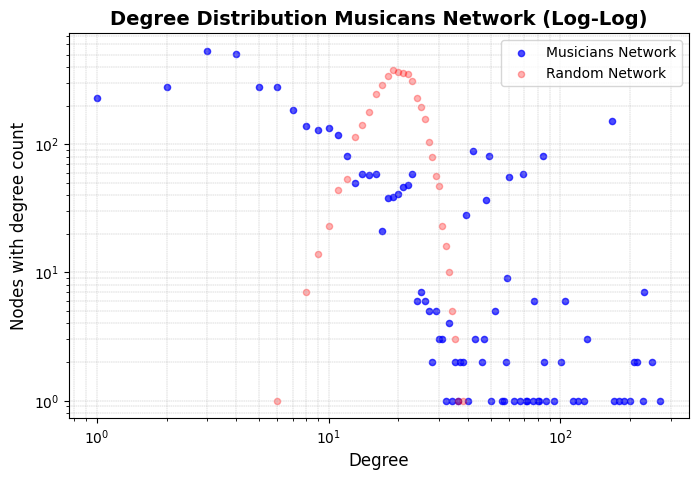

In [14]:
scatter_dist(G, F)